In [1]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr


In [3]:
## This function will help to plot 
def dos_plot (group_or_wc_list):
    from aiida.orm import load_group, load_node
    if group_or_wc_list == []:
        dos_list= group_or_wc_list
    else:
        try:
            group = load_group(group_or_wc_list)
            dos_list = [i.pk for i in list(group.nodes)[:]]
        except:
            print('{} group is not present is the database.'.format(group_or_wc_list))
   
    for wc in dos_list[:]:
        imp_dos = load_node(wc)
        imp_info = imp_dos.label
        print(imp_info)


        fig2 = plt.figure(figsize=(15.0,4.5))
        spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)

        

        # Total contribution from the entire impurity cluster
        f2_ax1 = fig2.add_subplot(spec2[0, 0])
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True ,label= 'Impurity_Clu1ter',
                     noshow=True, nofig=True, color='C'+str(0), filled=True, alpha=0.3, yscale=1
                )
        # highlight the contibution of the impurity (iatom=0)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label= imp_dos.label,
                     noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0, 
                )
        
            

        f2_ax2 = fig2.add_subplot(spec2[0, 1])
        plot_kkr(imp_dos, l_channels=True, strucplot=False, silent=True, label='Impurity_Cluster',
                noshow=True, nofig=True, color='C'+str(0),filled=True, alpha=0.3, yscale=1, sum_spins= True,)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
                noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)
        print('impurity_dict', imp_dos.inputs.impurity_info.get_dict())
        
        
        
## execution of the function
# dos_plot(94)

In [39]:
import numpy as np
group = load_group(94)
node_1 = list(group.nodes)[0]
print(node_1.inputs.impurity_info)
print(node_1.pk)
dos_data = (node_1.outputs.dos_data)
# print(node_1.outputs.last_calc_output_parameters.get_dict())#['magnetism_group']
x_label, x_data, x_unit = (dos_data.get_x())
y_total = dos_data.get_y()#[0]
lst = x_data[0][:]

uuid: 2bc11f33-e000-466c-9a73-64fc9118f408 (pk: 16192)
22896


In [41]:
ll = min(range(len(lst)), key = lambda i: abs(lst[i]-0.0))
print('ll : ',ll)
len(y_total[:][0])
# print(y_total[1][0][:], len(y_total[1][0][:]), y_total[1][:][0], len(y_total[1][:][0]))
print('x_data shape : ',x_data)
print('y_data shape : ',y_total[1])

ll :  63
x_data shape :  [[-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]
 [-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]
 [-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]
 ...
 [-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]
 [-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]
 [-10.          -9.84210526  -9.68421053 ...   4.68421053   4.84210526
    5.        ]]
y_data shape :  ('dos s', array([[0.00301125, 0.00281056, 0.00248993, ..., 0.19754974, 0.29107022,
        0.17234472],
       [0.00301125, 0.00281056, 0.00248993, ..., 0.19754972, 0.29107023,
        0.17234474],
       [0.00671304, 0.00576414, 0.00580446, ..., 0.06064234, 0.07442567,
        0.08719849],
       ...,
       [0.09200523, 0.11958139, 0.1329963 , ..., 0.00616494, 0.00870916,
        0.00715775],
       [0.09187341, 0.11931619, 0

In [42]:
x = x_data[1][:]
y_data = (y_total[1])
y =  y_data[-1][:]+y_data[-1][:]


In [240]:
# For the given input 'imp_dos node or ID and intended energy points' it will return .
# Total density of states arround the indent eng point, most prominent orbital (s,p,d,...) dos and corresponding
# dos value

def dos_spec(imp_dos_or_pk, atom_index = 0, eng=0, debug=False):
    
    import numpy as np
    from aiida.orm import load_node
    from aiida.common.exceptions import NotExistent 
    
    is_id = None
    node_exist = None
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk


    
    dos_data = dos_node.outputs.dos_data
    dos_data_x = dos_data.get_x()
    dos_data_y = dos_data.get_y()
    
    if debug:
        print('dos_data_x shape :', np.shape(dos_data_x))
        print('dos_data_y shape :', np.shape(dos_data_y))
    
    # extract the discrete energy list and unit
    discrete_eng, eng_unit = (dos_data_x[1])[0][:], dos_data_x[2]
    if debug:
        print('discrete_eng : ',discrete_eng)
        print('eng_unit : ', eng_unit)
    
    dos_unit = dos_data_y[0][2]
    if debug:
        print('dos_unit : ', dos_unit)
    
    ## In this part only the required dos data will be saved into the dos_data_arr 
    # cut the dos data for total, s, p, ... into that array for tot, s, p, d, more orbital.
   
    # number of dos array e.g., tot, s, p,..orbital
    num = np.shape(dos_data_y)[0]
    if debug:
        print('NUM : ', num)
    
    y_grid = num*2 # to count the spin and down
    x_grid = len(discrete_eng)
    
    if debug:
        print('x_grid, :', x_grid)
        print('y_grid, :', y_grid)

    dos_data_arr = np.zeros((y_grid,x_grid),dtype=float)
    if debug:
        if num == int(y_grid/2):
            print('ok')

    ## The array dos_data_arr consist dos data for the <atom_index> and for all ldos (total, s, p....,ns)
    for i in range(num): 
        l_dos = dos_data_y[i][1]
        dos_data_arr[i*2][:] =  l_dos[atom_index*2][:] # for spin up
        dos_data_arr[i*2+1][:] =  l_dos[atom_index*2 +1][:] # for spin down 
    if debug:    
        print('dos_data_arr shape: ',np.shape(dos_data_arr))
    
    # Find the energy index nearest to eng index
    nearest_eng_point_index = min(range(len(discrete_eng)), key= lambda i : abs(discrete_eng[i] - eng))
    if debug:
        print('min energy : ', nearest_eng_point_index)
    
    ## It returns all the dos along the column at the index <nearest_eng_point_index>
    all_dos = dos_data_arr.T[nearest_eng_point_index][:]
    
    if debug:
        print('shape of the all_dos', np.shape(all_dos))
        print('all_dos data : ',all_dos)
    
    ## total dos_density list at energy point <eng> for an atom <atom index>
    total_dos = [all_dos[0], all_dos[1]]
    ldos_u , ldos_d = [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==0 ], [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==1 ]
    # To collecting the lebel from dos_data
    total_dos_label = dos_data_y[0][0]
    #collect the ldos lebel for max_dos spin up and spin down
    ldos_u_label = dos_data_y[np.argmax(ldos_u[:]) + 1][0] 
    ldos_d_label = dos_data_y[np.argmax(ldos_d[:]) + 1][0]
    
    # Collect the max ldos value 
    max_ldos_up_value = np.max(ldos_u)
    max_ldos_down_value = np.max(ldos_d)
    
    # To collec the data for further invetigation e.g. ploting 
    out_dict = {total_dos_label: {total_dos_label+'_spin_up': total_dos[0],
                                      total_dos_label+'_spin_down': total_dos[1]},
                'Most Prominent_ldos': {ldos_u_label + '_spin_up': max_ldos_up_value,
                                      ldos_d_label + '_spin_down': max_ldos_down_value},
                'Units':{'energy_unit': eng_unit,
                         'dos_unit':dos_unit},
                'Other':{'eng':discrete_eng[nearest_eng_point_index],
                         'atom_index':atom_index}
               }
    
    return out_dict
    

In [248]:
## This function will return the desired value from the last calc output_parameters for the given input parameter
## and also some out_parameters from the kkr_imp_scf wc
def conv_dos_data(imp_dos_or_pk):
    import numpy as np
    from aiida.orm import load_node
    from aiida_kkr.workflows import kkr_imp_sub_wc
    from aiida.common.exceptions import NotExistent 
    summary_data_dict = { 'rms_conv' : 0,
                          'etot_conv_Ry' : 0,
                          'etot_conv_eV' : 0,
                          'imp_spin_moment_mu_Bhor' : 0,
                          'imp_orbital_moment_mu_Bhor' : 0,
                          'imp_total_charge_electron' : 0,
                          'imp_core_charge_electron' : 0,
                          'charge_doping_electron' : 0,
                          'DOS_in_gap' : 0,
                     }
    imp_clst_dict = {'atoms_in_impurity_cluster' : 0,
                     'ilayer' : 0,
                     'Zimp' : 0,
                     'Zhost' : 0
        
                      }
    
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk
    imp_info = dos_node.inputs.impurity_info.get_dict()
    scf_wc = dos_node.inputs.imp_pot_sfd.get_incoming(node_class = kkr_imp_wc).first().node
    scf_out_param = scf_wc.outputs.last_calc_output_parameters.get_dict()
    ## Filling the last calc output data
    imp_atom = 0
    summary_data_dict['rms_conv'] = scf_out_param['convergence_group']['rms']
    summary_data_dict['etot_conv_Ry'] = scf_out_param['total_energy_Ry']
    summary_data_dict['etot_conv_eV'] = scf_out_param['total_energy_Ry'] * 13.6056980659
    summary_data_dict['imp_spin_moment_mu_Bhor'] = scf_out_param['magnetism_group']['spin_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_orbital_moment_mu_Bhor'] = scf_out_param['magnetism_group']['orbital_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_total_charge_electron'] = scf_out_param['total_charge_per_atom'][imp_atom]
    summary_data_dict['imp_core_charge_electron'] = scf_out_param['charge_core_states_per_atom'][imp_atom]
    charge_doping = imp_info['Zimp'] - summary_data_dict['imp_total_charge_electron']
    summary_data_dict['charge_doping_electron'] = charge_doping
    
    spec_dos_data = dos_spec(dos_node, atom_index=imp_atom, eng=0)
    dos_in_gap = spec_dos_data['dos tot']['dos tot_spin_up'] + spec_dos_data['dos tot']['dos tot_spin_down']
    summary_data_dict['DOS_in_gap'] = dos_in_gap
    
    # Filling the imp_cluster data
    cluster_size = len(scf_out_param['total_charge_per_atom'])
    zimp = imp_info['Zimp']
    zhost = 0 # TODO: Have to find it later
    ilayer = imp_info['ilayer_center']
    
    imp_clst_dict['atoms_in_impurity_cluster'] = cluster_size
    imp_clst_dict['ilayer'] = ilayer
    imp_clst_dict['Zimp'] = zimp
    imp_clst_dict['Zhost'] = zhost
    return summary_data_dict, imp_clst_dict

In [249]:
## Test the dos_spec function
node_23937 = load_node(23937)
group = load_group(94)
node_1 = list(group.nodes)[6]

In [250]:
dct, imp_clst = conv_dos_data(node_1)
dct, imp_clst

({'rms_conv': 8.2655e-08,
  'etot_conv_Ry': -84273.9919684,
  'etot_conv_eV': -1146606.4895301322,
  'imp_spin_moment_mu_Bhor': [-9.6544141671731e-05,
   -2.1655082055001e-05,
   2.1030878357754],
  'imp_orbital_moment_mu_Bhor': [0.00077743887029323,
   -0.00022859176987891,
   -0.34429084837917],
  'imp_total_charge_electron': 26.489297,
  'imp_core_charge_electron': 18.0,
  'charge_doping_electron': 0.5107029999999995,
  'DOS_in_gap': 10.12546455971133},
 {'atoms_in_impurity_cluster': 15, 'ilayer': 3, 'Zimp': 27, 'Zhost': 0})

In [251]:
## Test the dos_spec function
dat = dos_spec(node_1)
dat

{'dos tot': {'dos tot_spin_up': 9.983145576039119,
  'dos tot_spin_down': 0.14231898367221246},
 'Most Prominent_ldos': {'dos d_spin_up': 9.990432186407535,
  'dos d_spin_down': 0.12571000207423627},
 'Units': {'energy_unit': 'eV', 'dos_unit': 'states/eV'},
 'Other': {'eng': -0.05263157894284976, 'atom_index': 0}}

In [252]:
scf_wc = node_1.inputs.imp_pot_sfd.get_incoming(node_class=kkr_imp_wc).first().node
# scf_wc.outputs.

In [253]:
kkr_calc = node_1.get_outgoing(node_class=kkr_imp_sub_wc).first().node.get_outgoing(node_class=KkrimpCalculation).first().node
kkr_calc.inputs.parameters.get_dict()
node_1.pk

22922

In [254]:
# To plot some data
group_ilayer_4 = load_group(93)
node_list = list(group_ilayer_4.nodes)
imp_list = []
gap_dos_list = []
for i in range(len(node_list)):
    dos_dict, clst_dict = conv_dos_data(node_list[i])
    imp_list.append(clst_dict['Zimp'])
    gap_dos_list.append(dos_dict['DOS_in_gap'])


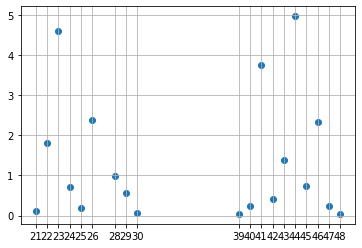

In [330]:
# plotting 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
# ax = plt.figure()

# plt.figure(num='imp_Vs_dos_gap',figsize=(10,5))
ax.scatter(imp_list,gap_dos_list)

xlabel= [str(i) for i in imp_list]
ax.set_xticks(imp_list)
ax.set_xticklabels(xlabel)
ax.grid(True)



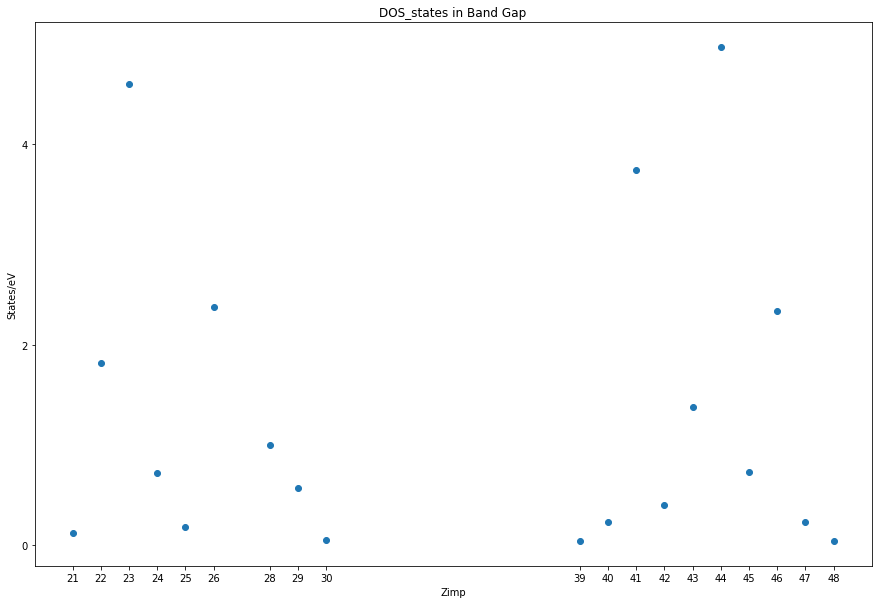

In [339]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(15,10))
gdspec.GridSpec(3,3)

plt.subplot2grid((1,1), (0,0), colspan=3, rowspan=3)
plt.scatter(imp_list, gap_dos_list)
plt.locator_params(axis='x', nbins=30)
plt.locator_params(axis='y', nbins=5)
plt.title('DOS_states in Band Gap')
plt.xlabel('Zimp')
plt.ylabel('States/eV')
plt.xticks(imp_list, xlabel)
plt.show()

In [302]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Generate data
dist_norm = np.random.normal(loc=0, scale=1, size=1000)
dist_tdis = np.random.standard_t(df=29, size=1000)
dist_fdis = np.random.f(dfnum=59, dfden=28, size=1000)
dist_chsq = np.random.chisquare(df=2, size=1000)

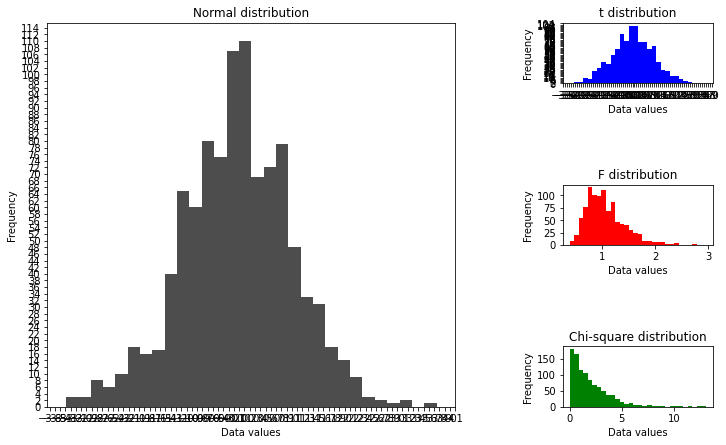

In [314]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Normal distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_norm, bins=30, color='0.30')

# small subplot 1
plt.subplot2grid((3,3), (0,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('t distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_tdis, bins=30, color='b')

# small subplot 2
plt.subplot2grid((3,3), (1,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('F distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_fdis, bins=30, color='r')

# small subplot 3
plt.subplot2grid((3,3), (2,2))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Chi-square distribution')
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.hist(dist_chsq, bins=30, color='g')

# fit subplots and save fig
fig.tight_layout()
fig.set_size_inches(w=11,h=7)
fig_name = 'plot.png'
fig.savefig(fig_name)